In [1]:
import theano.tensor as T
from theano import function
from theano import pp

# Note: the default data type without the 'd' prefix is float.
x = T.dscalar('x')
y = T.dscalar('y')

# Alternatives:
# 1. x, y = T.dscalars(2)
# 2. x, y = T.dscalars('x', 'y')
#
# Note that the output of `pp` will be ugly in case (1).

z = x + y
f = function([x, y], z)

pp(z)

'(x + y)'

In [2]:
# Properties of Theano classes.

from pprint import pprint

pprint(vars(x))
print(vars(x.type))

# Use this to get the data type of a variable.
print(x.type.dtype)

{'auto_name': 'auto_3',
 'index': None,
 'name': 'x',
 'owner': None,
 'tag': scratchpad{'trace': [('<ipython-input-1-cfa939c54768>', 6, '<module>', "x = T.dscalar('x')")]},
 'type': TensorType(float64, scalar)}
{'sparse_grad': False, 'numpy_dtype': dtype('float64'), 'dtype': 'float64', 'name': None, 'broadcastable': ()}
float64


In [3]:
# Matrix computations.

x, y = T.dmatrices('x', 'y')
z = x + y
f = function([x, y], z)

print(pp(z))
f([[1, 2], [3, 4]], [[1, 0], [0, 1]])

(x + y)


array([[ 2.,  2.],
       [ 3.,  5.]])

In [184]:
# A somewhat less trivial example.

a, b = T.vectors('a', 'b')
out = (a + b) ** 2
f = function([a, b], out)

print(pp(out))
f([1, 2, 3], [4, 5, 6])

((a + b) ** TensorConstant{2})


array([ 25.,  49.,  81.])

In [3]:
# To get pydot to work for Python 3.4, I used
# sudo pip install git+https://github.com/nlhepler/pydot

from theano.printing import debugprint, pydotprint
from IPython.display import display, Image, SVG

# Display as SVG.

def show_graph(var):
    display(SVG(pydotprint(var, return_image=True, format='svg')))
    
def graph_to_png(var):
    display(Image(pydotprint(var, return_image=True, format='png'), retina=True))

# The unoptimized graph.
show_graph(out)
# The optimized graph.
show_graph(f)

# Display as PNG.
# display(Image(pydotprint(out, return_image=True, format='png'), retina=True))

In [179]:
# Initialize sympy.

from sympy import init_printing

init_printing()
x, y = symbols('x y')
display(x + y)

In [180]:
# Computing scalar derivatives.

x = T.dscalar('x')
y = x ** 2

# Note that the first argument to `grad` must be a scalar quantity. We have
# to use `jacobian` or `scan` in order to compute derivatives of non-scalar
# valued expressions.
dy = T.grad(y, x)

# In the output below, `fill((x ** 2), 1)` creates an array of the same shape
# as `x ** 2`, and fills it with ones.
print(theano.pp(dy))

((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))


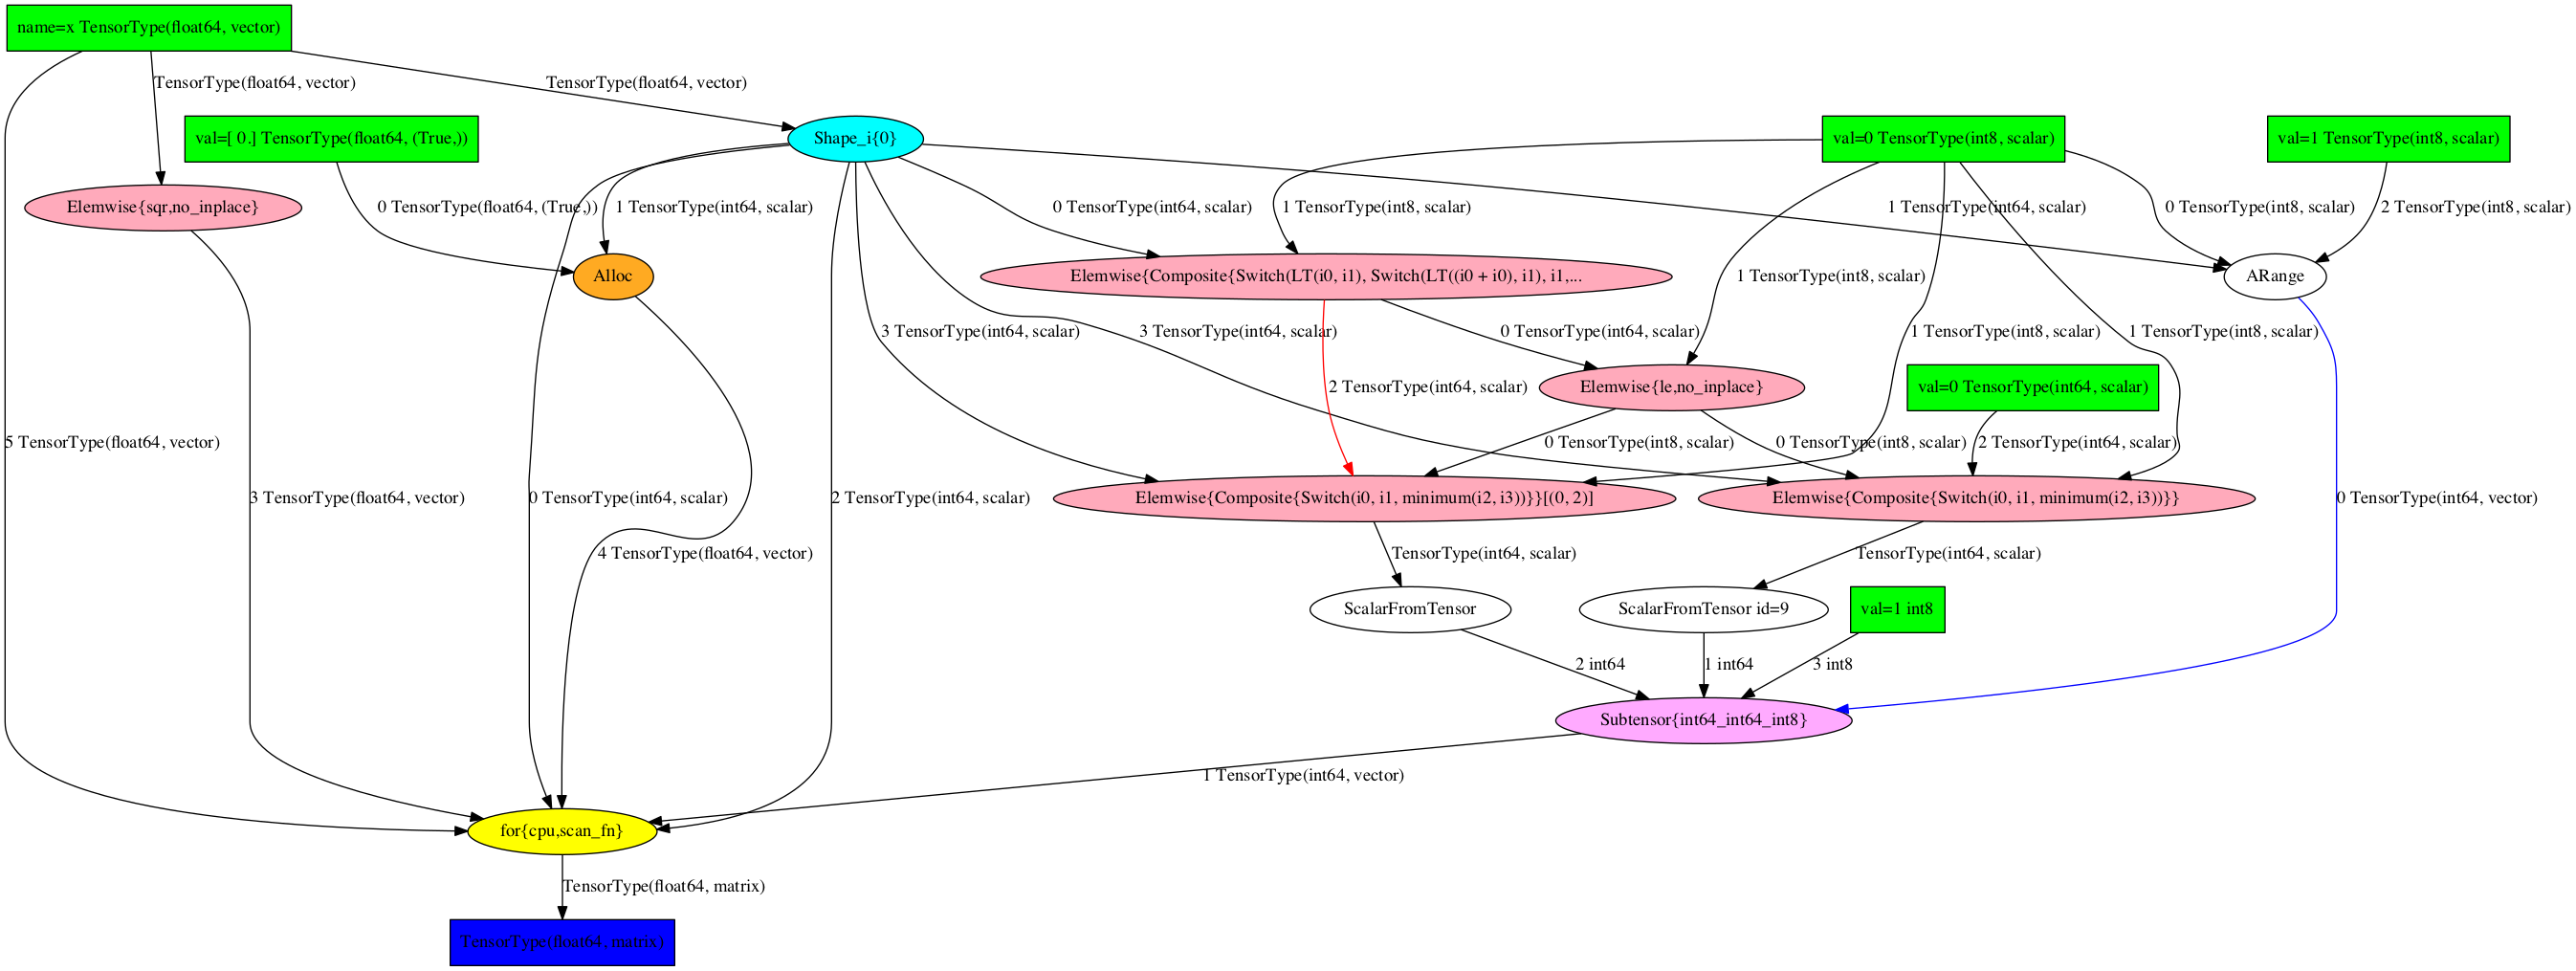

In [191]:
# Computing non-scalar derivatives. Note that this example takes a while when
# run for the first time, due to the code generation process.

from IPython.core.display import HTML

x = T.dvector('x')
y = x ** 2
J, _ = theano.scan(lambda i, y, x : T.grad(y[i], x),
    sequences=T.arange(y.shape[0]), non_sequences=[y, x])

f = function([x], J)
f([4, 4])
    
# TODO: Why is the computation graph so large for this simple operation, and what
# is happening? Why is memory allocated each time?
graph_to_png(f)
#print(debugprint(f))

[[ 8.  0.]
 [ 0.  8.]]


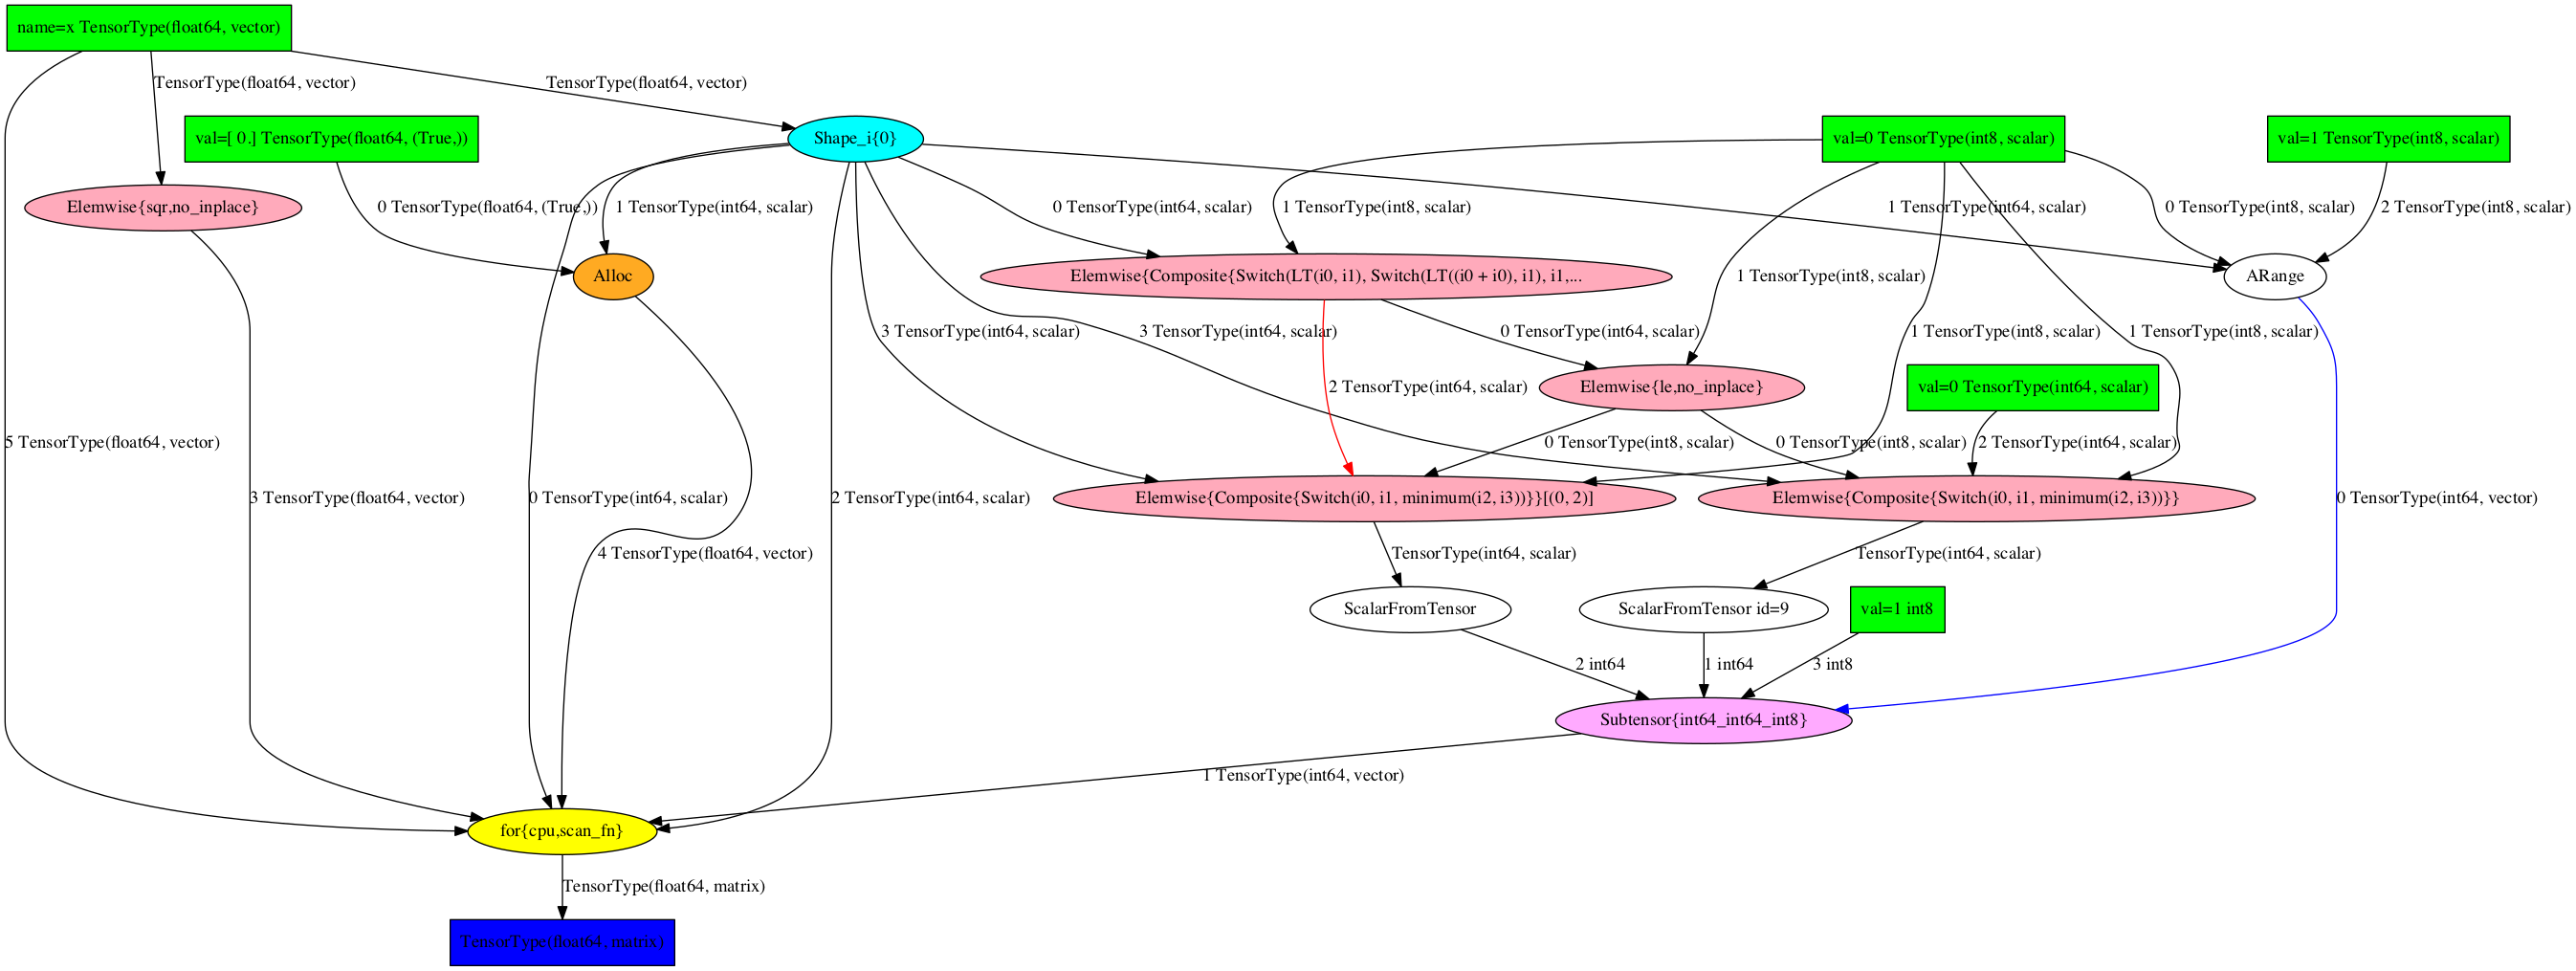

In [192]:
# Same as above, but using the existing Jacobian function.

from theano.gradient import jacobian

x = T.dvector('x')
y = x ** 2
J = jacobian(y, x)

f = function([x], J)
print(f([4, 4]))

graph_to_png(f)

[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]

Graph of f1:

for{cpu,scan_fn} [@A] ''   0
 |TensorConstant{10} [@B]
 |TensorConstant{10} [@B]
 |x [@C]

Inner graphs of the scan ops:

for{cpu,scan_fn} [@A] ''   
 >DeepCopyOp [@D] 'x_copy'   
 > |x_copy [@E]
None

Graph of f2:

Alloc [@A] ''   0
 |TensorConstant{1.0} [@B]
 |TensorConstant{10} [@C]
None


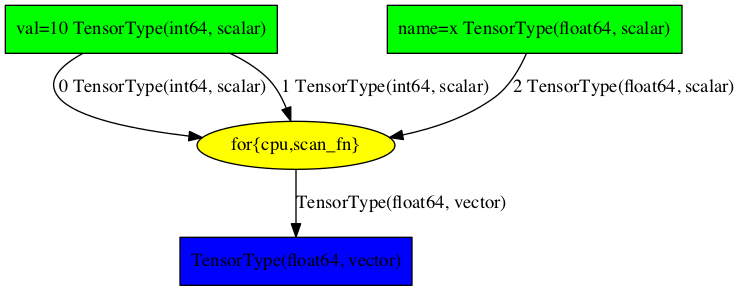

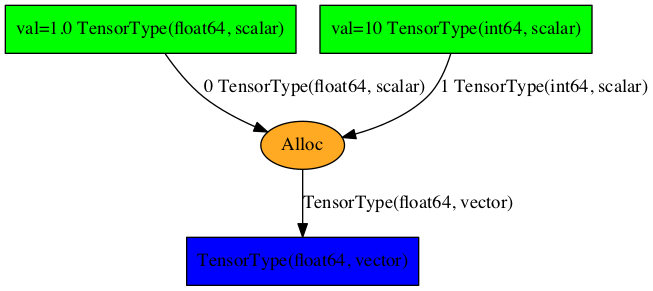

In [859]:
# Computation graphs of simple scans.

import theano
from theano.gradient import jacobian

x = T.dscalar('x')
y1, _ = theano.scan(lambda _ : x, sequences=T.arange(10))
y2, _ = theano.scan(lambda _ : T.grad(x, x), sequences=T.arange(10))
f1 = function([x], y1)
f2 = function([x], y2)
print(f1(2))
print(f2(2))

print("\nGraph of f1:\n")
print(debugprint(f1))
print("\nGraph of f2:\n")
print(debugprint(f2))
graph_to_png(f1)
graph_to_png(f2)

# Observations:
#
# Example 1. When filling an array with a variable scalar using `scan`, Theano
# repeatedly calls `DeepCopyOp` in a loop. Question: where does the allocation
# happen here, and how many allocations are made? Inspecting the generated code
# suggests that only one allocation is made. The generated C code performs the
# actual data transfer from the source array to the destination array.
#
# Example 2. When filling an array with a constant scalar using `scan`, Theano
# calls `Alloc` (probably its custom allocation function for Theano-managed
# memory) with the corresponding size and initial value.

[[ 1.  2.  3.]
 [ 1.  2.  3.]
 [ 1.  2.  3.]]
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]

Graph of f1:

for{cpu,scan_fn} [@A] ''   0
 |TensorConstant{3} [@B]
 |TensorConstant{3} [@B]
 |x [@C]

Inner graphs of the scan ops:

for{cpu,scan_fn} [@A] ''   
 >DeepCopyOp [@D] 'x_copy'   
 > |x_copy [@E]
None

Graph of f2:

for{cpu,scan_fn} [@A] ''   2
 |TensorConstant{3} [@B]
 |TensorConstant{[0 1 2]} [@C]
 |TensorConstant{3} [@B]
 |x [@D]
 |Alloc [@E] ''   1
   |TensorConstant{(1,) of 0.0} [@F]
   |Shape_i{0} [@G] ''   0
     |x [@D]

Inner graphs of the scan ops:

for{cpu,scan_fn} [@A] ''   
 >IncSubtensor{Inc;int8} [@H] ''   
 > |<TensorType(float64, vector)> [@I]
 > |TensorConstant{1.0} [@J]
 > |ScalarFromTensor [@K] ''   
 >   |<TensorType(int8, scalar)> [@L]
None


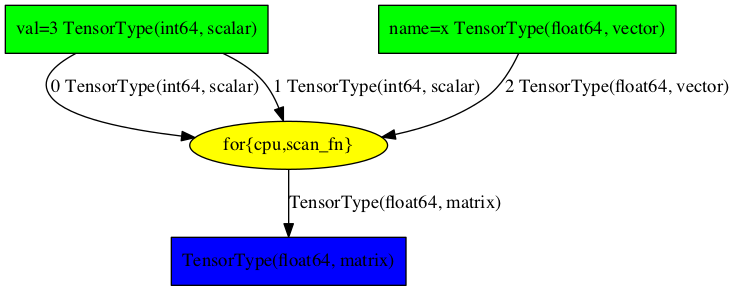

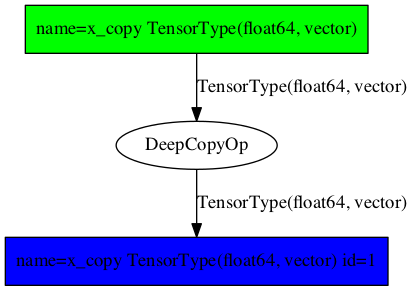

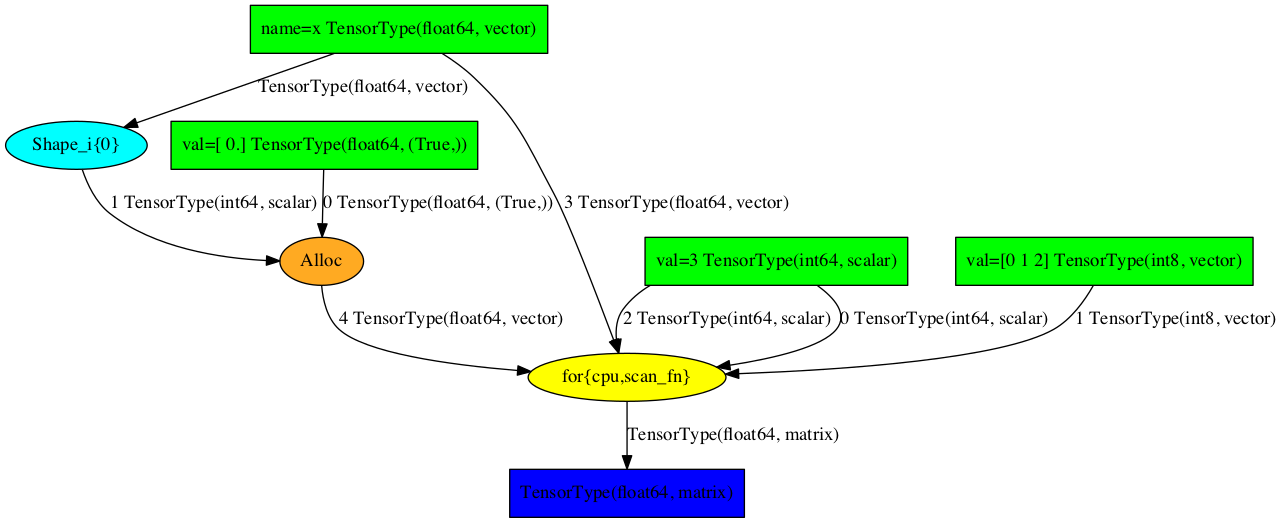

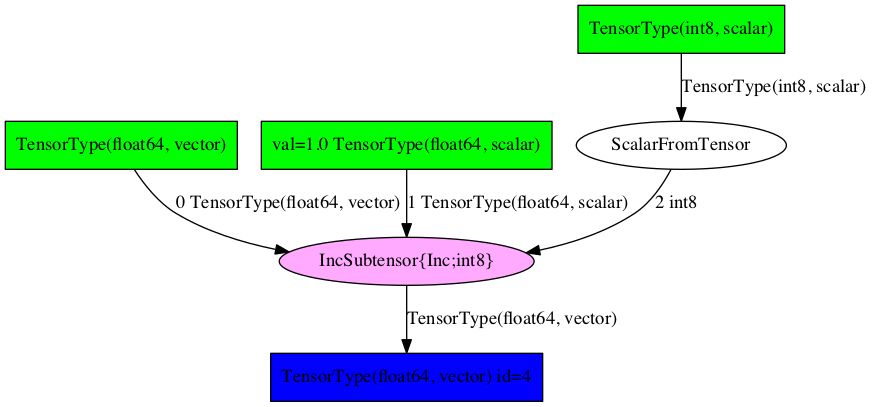

'\nObservations:\nExample 1.\n\nExample 2. In the optimizated computation graph for `f2`, five inputs are\npassed to the `Apply` node for the scan function. These inputs are 3,\n[0, 1, 2], 3, x, and the output of an `Alloc` operation. The vector\n[0, 1, 2] comes from the `arange` operation, and the output of the `Alloc`\noperation is the zero vector of size three.\n\n\n'

In [874]:
# Computation graphs of simple scans.

from theano.gradient import jacobian

x = T.vector('x')
y1, _ = theano.scan(lambda _ : x, sequences=T.arange(3))
y2, _ = theano.scan(lambda i : T.grad(x[i], x), sequences=T.arange(3))
f1 = function([x], y1)
f2 = function([x], y2)
print(f1([1, 2, 3]))
print(f2([1, 2, 3]))

print("\nGraph of f1:\n")
print(debugprint(f1))
print("\nGraph of f2:\n")
print(debugprint(f2))
graph_to_png(f1)
graph_to_png(f1.maker.fgraph.outputs[0].owner.op.fn.maker.fgraph)

graph_to_png(f2)
graph_to_png(f2.maker.fgraph.outputs[0].owner.op.fn.maker.fgraph)

"""
Observations:
Example 1. In this case, each iteration of scan performs a deep copy of
x. The deep copy of x is also allocated as part of this operation.

Hypothesis: x_copy is just a shallow copy of x. What would the purpose of
making a shallow copy be? Why not just use x directly?

Questions:
- In both examples 1 and 2, each row of the output matrix seems to be
  allocated separately. Can these allocations be consolidated?
- Is there a way to monitor all external memory allocations made by Theano?
  This would allow us to test our conclusions about how memory is being
  managed.

Example 2. In the optimizated computation graph for `f2`, five inputs are
passed to the `Apply` node for the scan function. These inputs are 3,
[0, 1, 2], 3, x, and the output of an `Alloc` operation. The vector
[0, 1, 2] comes from the `arange` operation, and the output of the `Alloc`
operation is the zero vector of size three.

The inner operation performed within the scan function takes only three
inputs: the current index obtained from the `sequences` parameter to
`theano.scan` (call this ind), x_copy, and the output of the `Alloc`
operation (call this x_new).

Questions:
- How is x_copy related to x? Is it a deep copy or a shallow copy?
- Since the `Alloc` operation happens outside the scan function, does this
  mean that only x is only copied once?
- Where is the memory for the vector produced during each iteration of the
  scan operation allocated?
- The result of the scan operation is a matrix, but (to my unerstanding)
  each row is allocated independently. Does this mean that the matrix is
  discontiguous, or is the output of the scan operation copied again into
  another array for the output matrix?
  
This inner operation performs an `IncSubtensor` operation on x_new, i.e.
x_new[ind] is incremented by one.

Hypotheses:
- x_new must be reinitialized to [0, 0, 0] during each iteration of the scan
  operation for the results to be valid. The most likely explanation seems
  to be that the `Alloc` operation is actually performed at each iteration.
  x_new is probably the name for this operation; each time it is invoked, a
  new zero vector is allocated and returned by `Alloc`.
- How can we verify assertions like those made above? Is there a way to
  visualize the relationship betweeen inputs and outputs in the computation
  graph?
  
After the three iterations of scan, we get three coordinate vectors.
Concatenating these together results in the identity matrix.
"""

# During each iteration of
# the scan operation, a copy of x (called x_copy) is passed to the `IncSubTensor`
# operation. The other two arguments to this operation are the outputs of
# `tensor.second` and `tensor.ScalarFromTensor`, respectively. The `tensor.second`
# operation always returns one, so I don't know why the computation graph hasn't
# been simplified after optimization. Strangely, printing out the computation graph
# using `debugprint` hides the entire `tensor.second` subtree and just shows `1` in
# its place. However, manually traversing the nodes reveals that this operation is
# still part of the computation graph. The `ScalarFromTensor` operation just returns
# the current token of the input sequence for the scan operation. In our case, this
# is the return value of the `arange` operation, which is [0, 1, 2]. So during the
# ith iteration, 0 <= i <= 2, `IncSubtensor` increments the ith component of x_copy
# by one. After each iteration, the modified version of x_copy is appended to the
# tuple of results. Finally, the three vectors resulting from the three iterations of
# scan are concatenated, resulting in the identity matrix.
#
# Question: since the `IncSubtensor` operation is not performed in-place, why is there
# an `Alloc` operation before the scan? Can't we work directly with x instead of using
# a redundant copy?
#
# Question: is it possible to see the values of each node in the computation graph,
# once `f` is evaluated? How can one figure out what various parts of the computation
# graphs are doing, especially when `f` is very complex?

In [888]:
"""
Custom function to print out computation graphs, written mostly as an
exercise. The input to the function can be a variable, function, or
function graph. We recursively make our way up the computation tree by
passing from a variable to its owner (an `Apply` node), or from an
`Apply` node to its inputs (which are `Variable` nodes). See this link
for more information:

  http://deeplearning.net/software/theano/tutorial/symbolic_graphs.html

Similar to `debug_print`, we also print the inner computation graphs for
scan operations. Unlike `debug_print`, however, we make no effort to
condense the output. The purpose of this function is to produce a faithful
representation of the computation graph, rather than one that is optimized
for legibility.
"""

from theano import compile, gof, tensor

def print_graph(obj, depth=0, msg=""):
    var_fmt_1 = "  |" * depth + "> {}{}"
    var_fmt_2 = "  |" * depth + "> {}{} ({})"
    var_fmt_3 = "  |" * depth + "> {}Output {} ({}) of operation"
    func_fmt  = "  |" * depth + "> {}{}: {} -> {}"
    
    if isinstance(obj, tensor.Variable):
        """
        Print out a useful summary of the variable.
        - We always print out the variable's type.
        - If the variable was given a name, then we print it.
        - Else if the variable is a constant, then we print its value.
        - Else if the variable has an index, then we know that the next node we
          to be visited is the `Apply` node of the function that produced it. So
          we print the index and proceed.
        - As a last resort, we print the string representation of the variable.
        """
        
        if obj.name:
            print(var_fmt_2.format(msg, obj.name, type(obj).__name__))
        elif isinstance(obj, gof.Constant):
            print(var_fmt_1.format(msg, str(obj)))
        elif obj.index is not None:
            print(var_fmt_3.format(msg, obj.index, type(obj).__name__))
        else:
            print(var_fmt_2.format(msg, str(obj), type(obj).__name__))
            
        if obj.owner:
            print_graph(obj.owner, depth + 1)
    elif isinstance(obj, gof.Apply):
        input_types = [type(x).__name__ for x in obj.inputs]
        output_types = [type(x).__name__ for x in obj.outputs]
        
        print(func_fmt.format(msg, str(obj.op), str(input_types),
            str(output_types)))
        
        for idx, i in enumerate(obj.inputs):
            print_graph(i, depth + 1, "Input {}: ".format(idx))
            
        if hasattr(obj, 'op') and hasattr(obj.op, 'fn'):
            # We also display an array that indicates which inputs from
            # the outer operation map to which inputs from the inner
            # operation.
            print_graph(obj.op.fn.maker.fgraph, depth + 1, "Inner graph ({}): ".
                format(obj.op.get_outer_iidx_from_inner_iidx_seq()))
    elif isinstance(obj, compile.Function):
        input_types = []
        output_types = []
        
        if hasattr(obj, 'inputs'):
            input_types = [type(x).__name__ for x in obj.inputs]
        if hasattr(obj, 'outputs'):
            output_types = [type(x).__name__ for x in obj.outputs]
        
        print(func_fmt.format(msg, str(obj), str(input_types),
            str(output_types)))
        
        for idx, o in enumerate(obj.maker.fgraph.outputs):
            print_graph(o, depth + 1, "Output {}: ".format(idx))
    elif isinstance(obj, gof.FunctionGraph):
        input_types = [type(x).__name__ for x in obj.inputs]
        output_types = [type(x).__name__ for x in obj.outputs]
        
        print(func_fmt.format(msg, obj.name, str(input_types),
            str(output_types)))
        
        for idx, i in enumerate(obj.inputs):
            print_graph(i, depth + 1, "Input {}: ".format(idx))
        for idx, o in enumerate(obj.outputs):
            print_graph(o, depth + 1, "Output {}: ".format(idx))
    else:
        raise RuntimeError("Unsupported node type {}.".format(type(obj).__name__))

In [892]:
# A comparison of Theano's debugprint and the print_graph function above.

from pprint import pprint

print("*** debugprint ***\n\n")
debugprint(f2)

print("\n\n*** print_graph ***\n\n")
print_graph(f2)



*** print_graph ***


> <theano.compile.function_module.Function object at 0x10877c940>: [] -> ['SymbolicOutput']
  |> Output 0: Output 0 (TensorVariable) of operation
  |  |> for{cpu,scan_fn}: ['TensorConstant', 'TensorConstant', 'TensorVariable'] -> ['TensorVariable']
  |  |  |> Input 0: TensorConstant{3}
  |  |  |> Input 1: TensorConstant{3}
  |  |  |> Input 2: x (TensorVariable)
[2]
  |  |  |> Inner graph ([2]): scan_fn: ['TensorVariable'] -> ['TensorVariable']
  |  |  |  |> Input 0: x_copy (TensorVariable)
  |  |  |  |> Output 0: x_copy (TensorVariable)
  |  |  |  |  |> DeepCopyOp: ['TensorVariable'] -> ['TensorVariable']
  |  |  |  |  |  |> Input 0: x_copy (TensorVariable)


In [557]:
# TODO
# Stuff based on the "Extending Theano" tutorial here:
# http://deeplearning.net/software/theano/extending/index.html.